In [9]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

from Libs.libs import *

In [10]:
from Libs.libs import llm
from langchain_core.tools import tool
from Libs.libs import *
from typing import Literal
import pandas as pd


def availabilityy(desired_date: str, doctor_name: str):
    desired_date_split = desired_date.split("T") or desired_date
    print("desired date is:", desired_date)
    df = pd.read_csv(f"./data/syntetic_data/availability.csv")
    date = desired_date_split[0]
    time = desired_date_split[1] if len(desired_date_split) > 1 else ""
    print(time)
    # query = doctor_name+ " for " + date + " at time: " +time
    query = doctor_name + " for " + date + "," + time
    # print(f"{df['date_slot'].apply(lambda x: x.split(' '))}", query)
    availability = pd.DataFrame()
    if time != "":
        availability = df[
            (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
            & (df["date_slot"].apply(lambda x: x.split(" ")[1]) == time)
            & (doctor_name == df["doctor_name"])
            & (df["is_available"] == True)
        ]
        if availability.empty:
            availability = df[
                (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
                & (doctor_name == df["doctor_name"])
                & (df["is_available"] == True)
            ]
        return query, availability
    availability = df[
        (df["date_slot"].apply(lambda x: x.split(" ")[0]) == date)
        & (doctor_name == df["doctor_name"])
        & (df["is_available"] == True)
    ]
    print("---->>>>>>>", availability, ">>>-----", query)
    return query, availability


@tool
def check_availability_by_doctor(
    desired_date: str,
    doctor_name: Literal[
        "kevin anderson",
        "robert martinez",
        "susan davis",
        "daniel miller",
        "sarah wilson",
        "michael green",
        "lisa brown",
        "jane smith",
        "emily johnson",
        "john doe",
    ],
):
    # desired_date, doctor_name:Literal['kevin anderson','Ajeet','Rajesh','Shiva','Ganesh',]):
    """
    Check the availability of the doctor with the name of the doctor and date of availability provided
    """
    # print(desired_date)
    print("from check availability by doctor tool")
    query, availability = availabilityy(
        desired_date=desired_date, doctor_name=doctor_name
    )
    print("Tool entered with the query", query)
    # print(availability)
    template = """
    You have to answer the user query which is about the availability of a doctor inquired by patient. You are also given a context that contains the doctors available in that day and a time slot. Analyze and return the doctor name, date and available time slot. 
        Context inside double backticks:`{context}`
        Question inside triple backticks:{question}
        Response in markdown format without any backticks and in the context phrase just answer what is asked and if the doctor is not available for a particular time slot, recomend the other time slots.

        Your response should be very much conversational in such a way that you are a receptionist talking to a patient who is here to schedule an appointment.
        """
    prompt = ChatPromptTemplate.from_template(template)
    # print("context>>>>>>>>>>>>>>>>",database.similarity_search(query,k=5))
    chain = (
        RunnableMap(
            {"context": lambda x: availability, "question": lambda x: x["question"]}
        )
        | prompt
        | llm
        | string_parser
    )
    result = chain.invoke({"question": query})
    print("------------")
    mdprint(result)
    print("------------")
    return {"messages": result}

    # outpur = ""
    # if len(availability) == 0:
    #     outpur = "Doctor not available for the day"
    #     return llm.invoke(input=f"Your should return this text in a markdown format in a good language No doctors are available for {availability}"  )
    # else:
    #     outpur = f"Availablity for the doctor {doctor_name}is+ ""+{availability}".join(availability)
    #     return llm.invoke(input=f"Your should return this text in a markdown format in a good language No doctors are available for {outpur}"  )

    # return outpur
    


def availability_by_specialization(desired_date:str, specialization:str):
    desired_date_split = desired_date.split("T") or desired_date

    date =  desired_date_split[0] 
    time = desired_date_split[1] if len(desired_date_split) > 1 else "" 
    df = pd.read_csv(f"./data/syntetic_data/availability.csv")
    rows = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == date) & (df['specialization'] == specialization) & (df['is_available'] == True)].reset_index()
    available_specialization = rows[['date_slot', 'specialization', 'doctor_name']] 
      
    query = specialization+ " for " + date + "," +time
    print()
    print()
    print()
    print()
    return query, available_specialization
    

@tool
def check_availability_by_specialization(desired_date:str, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Check the availability of the doctor with specialization and date provided.
    """
    print("from check availability by doctor tool")
    # specialization = "orthodontist"
    # desired_date = "2024-09-03"
    
    query, available_specialization = availability_by_specialization(desired_date=desired_date, specialization=specialization)
    print("Tool entered with the query", query)

    template = """
    You have to answer the user query in which patient is searching for a doctor of a particular specialization which is given in the query. You are also given a context that contains the doctors available in that day and a time slot. Analyze and return the doctor name, date and available time slot along with the specialization. 
        Context inside double backticks:`{context}`
        Question inside triple backticks:{question}
    Response in markdown format without any backticks and in the context phrase just answer what is asked and if the doctor is not available for a particular time slot, recomend the other time slots.
    Your response should be very much conversational in such a way that you are a receptionist talking to a patient who is here to schedule an appointment.

        """
    prompt = ChatPromptTemplate.from_template(template)
    # print("context>>>>>>>>>>>>>>>>",database.similarity_search(query,k=5))
    chain = RunnableMap({
        "context":lambda x: available_specialization,
        "question": lambda x: x['question']
    }) | prompt | llm | string_parser
    result = chain.invoke({'question':query})
    mdprint(result)
    return {"messages":result} 
   
    
from Tools.availability_by_doctor import *
from Tools.availability_by_specialization import *

@tool
def book_appointment(desired_date:str, desired_time:str,  doctor_name:str):
    """
    When the user wants to book an appointment for a doctor at a specified time.

    """
    patient_id = "abcded"
    patient_name = "Ajeet Acharya"
    print("book tool activated", desired_date, " ", desired_time)
    availability = pd.DataFrame()
    specializations = pd.DataFrame()
    # if specialization =="":
    desired_date_time = f"{desired_date}T{desired_time}"
    _, availability = availabilityy(desired_date=desired_date_time, doctor_name=doctor_name)
    availability_new = availability[["date_slot","specialization","doctor_name"]]
    if len(availability) ==1:
        date_id_booking = availability.index[0]
        date_slot_booking = availability['date_slot'].iloc[0]
        time, date = date_slot_booking.split(" ")[0],  date_slot_booking.split(" ")[1]
        time = desired_time.split(":")
        final_time = f"{time[0]}:{time[1]}"
        if final_time == desired_time:
            doctor_name_booking = availability['doctor_name'].iloc[0]
            specialization_booking = availability['specialization'].iloc[0]
            data = pd.DataFrame({
                "patient_id":[patient_id],
                "doctor_time_id":[date_id_booking],
                "patient_name":[patient_name],
                "doctor_name":[doctor_name_booking],
                "appointment date time":[final_time],
                "appointment time":[desired_date],
                "specialization":[specialization_booking]
            })
            
            message = write_to_excel(data=data, date_id_booking=date_id_booking, patient_id=patient_id)
            print("Data written to Excel successfully!")
            return message
    else: 
        return f"The time slot {desired_time} is not available for {doctor_name}. Please select one of the.\n {availability_new}"


def write_to_excel(data, date_id_booking, patient_id):
    data.to_excel("./Appointment/doctor_appointments.xlsx")  # 'index=False' prevents writing row numbers
    book_appointment_path = r"data/syntetic_data/availability.csv"
    df = pd.read_csv(book_appointment_path)
    column_no = date_id_booking-2
    df.iloc[column_no, 'is_available'] = False
    df.iloc[column_no,'patient_to_attend'] = patient_id
    df.to_csv(book_appointment_path, index=False)

    return "Booking has been made sucessfully"

    

In [11]:
tools_available = [check_availability_by_specialization, check_availability_by_doctor, book_appointment]

## Agent Node

In [12]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

## Supervisor agent

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

members = ["ByDoctor_Spec", "BookAppointment"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH. Only invoke one worker at once. If the worker cannot provide answer, you should FINISH"
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members


class routeResponse(BaseModel):
    next: Literal["ByDoctor_Spec", "BookAppointment", "FINISH"]


prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# llm = ChatOpenAI(model="gpt-4o")


def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [14]:
import functools
import operator
from typing import Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


ByDoctor_Spec = create_react_agent(llm, tools=[check_availability_by_doctor, check_availability_by_doctor])
bookAppointment = create_react_agent(llm, tools=[book_appointment])
ByDoctor_Spec_node = functools.partial(agent_node, agent=ByDoctor_Spec, name="ByDoctor_Spec")
bookAppointment_node = functools.partial(agent_node, agent=bookAppointment, name="BookAppointment")

# # NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
# code_agent = create_react_agent(llm, tools=[python_repl_tool])
# code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

workflow = StateGraph(AgentState)
workflow.add_node("ByDoctor_Spec", ByDoctor_Spec_node)
workflow.add_node("BookAppointment", bookAppointment_node)
workflow.add_node("agent", supervisor_agent)

In [15]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "agent")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("agent", lambda x: x["next"], conditional_map)

# Finally, add entrypoint
workflow.add_edge(START, "agent")

graph = workflow.compile()

In [16]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content=" book an appointment for doctor kevin anderson on september 3 2024 at 8:00?")
        ]
    },
        {"recursion_limit": 100}

):
    if "__end__" not in s:
        print(s)
        print("----")

{'agent': {'next': 'BookAppointment'}}
----
book tool activated 2024-09-03   08:00
desired date is: 2024-09-03T08:00
08:00
book tool activated 2024-09-03   08:00
desired date is: 2024-09-03T08:00
08:00
{'BookAppointment': {'messages': [HumanMessage(content='It seems that the time slot of 08:00 on September 3, 2024, is not available for Dr. Kevin Anderson. Unfortunately, there are no available time slots listed.\n\nWould you like to choose a different date or time?', additional_kwargs={}, response_metadata={}, name='BookAppointment')]}}
----
{'agent': {'next': 'FINISH'}}
----


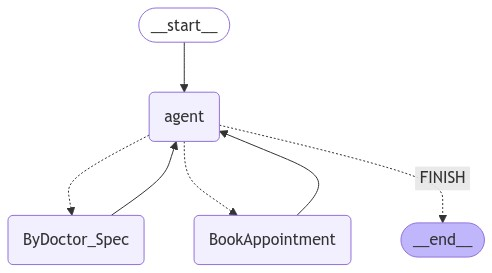

In [25]:
# from Agent.agent_take2 import *
from Libs.libs import *
# from graph import  graph

from IPython.display import Image, display


display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [26]:



from Libs.libs import *


from Tools.availability_by_doctor import *
from Tools.availability_by_specialization import *
from Tools.booking import book_appointment

class MessagesState(TypedDict):
    messages: Annotated[List[AnyMessage], operator.add]
    senderId:str
    history:str
    
    
tools_available = [book_appointment,check_availability_by_doctor, check_availability_by_specialization]
# tool = [mercedes_tool]
tool_node = ToolNode(tools=tools_available)
model = llm.bind_tools(tools = tools_available, strict=True)

def read_human_feedback(state):
    return state

def call_model(state: MessagesState):
    
    print("From call_model the state is:",state['senderId'])
    s = getData(state["senderId"])
    state["history"] = s
    

    # history = {"human_feedback":state["messages"][1], "AI":"This is ai response"}
    messages = [SystemMessage(content=f"You are helpful assistant.\n.As reference, today is {datetime.now().strftime('%Y-%m-%d %H:%M, %A')}\nKeep a friendly, professional tone.\nAvoid verbosity.\nConsiderations:\n- Don´t assume parameters in call functions that it didnt say.\n- MUST NOT force users how to write. Let them write in the way they want.\n- The conversation should be very natural like a secretary talking with a client.\n- Call only ONE tool at a time.")] + state['messages']
    # messages = [SystemMessage(content="You are a helpful assistant. As reference, today is {datetime.now().strftime('%Y-%m-%d %H:%M, %A')}. Always use tools to answer the queries")]

    response = model.invoke(messages)
    return {"messages": [response]}

def should_continue(state: MessagesState) -> Literal["tools", "human_feedback"]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "human_feedback"




def should_continue_with_feedback(state: MessagesState) -> Literal["agent", "end", "human_feedback"]:
    messages = state['messages']
    last_message = messages[-1]
    if isinstance(last_message, dict):
        if last_message.get("type","") == 'human_feedback':
            return "agent"
    if (isinstance(last_message, HumanMessage)):
        return "agent"
    if (isinstance(last_message, AIMessage)):
        return "end"
    return "end"



def graph(query:str, senderId:str):
    workflow = StateGraph(MessagesState)
    workflow.add_node("agent",call_model)
    workflow.add_node("tools",tool_node)
    workflow.add_node("human_feedback", read_human_feedback)


    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {"human_feedback":"human_feedback",
        "tools":"tools"}
    )
    workflow.add_conditional_edges(
        "human_feedback",
        should_continue_with_feedback,
        {"agent":"agent","end":END}
    )

    workflow.add_edge("tools","agent" )


    workflow.set_entry_point('agent')



    graph = workflow.compile()
    inputs = {"messages":[HumanMessage(content=query)], "senderId":senderId}

    for response in graph.stream(inputs):
        try:
            if "__end__" not in response:
                print(response)
                # if 'human_feedback' in response:
                token_usage =response['human_feedback']['messages'][-1].response_metadata['token_usage']
                final_response =  response['human_feedback']['messages'][-1].content
                    
                print("-----")
                # history = {"human_feedback":query, "ai":final_response}
                return {"result": final_response, "token_usage":token_usage}
        except Exception as e:
            print("error", e)



